In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
!pip install wget

In [3]:
import zipfile

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [4]:
import os

for dirpath, dirname, filename in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirname)} directories and {len(filename)} images in {dirpath}")

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent\test
There are 0 directories and 250 images in 10_food_classes_10_percent\test\chicken_curry
There are 0 directories and 250 images in 10_food_classes_10_percent\test\chicken_wings
There are 0 directories and 250 images in 10_food_classes_10_percent\test\fried_rice
There are 0 directories and 250 images in 10_food_classes_10_percent\test\grilled_salmon
There are 0 directories and 250 images in 10_food_classes_10_percent\test\hamburger
There are 0 directories and 250 images in 10_food_classes_10_percent\test\ice_cream
There are 0 directories and 250 images in 10_food_classes_10_percent\test\pizza
There are 0 directories and 250 images in 10_food_classes_10_percent\test\ramen
There are 0 directories and 250 images in 10_food_classes_10_percent\test\steak
There are 0 directories and 250 images in 10_food_classes_10_percent\test\sushi
There are 10 directori

In [5]:
import tensorflow as tf

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

Image_Shape = (224,224)
size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(train_dir, batch_size=size, class_mode='categorical', 
                                               target_size = Image_Shape)

test_data = test_datagen.flow_from_directory(test_dir, batch_size=size, class_mode='categorical', 
                                             target_size=Image_Shape)

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [8]:
from tensorflow.keras.callbacks import TensorBoard

In [9]:
import datetime

def create_tb_callback(dir_name, exp_name):
    log_dir = dir_name + "/" + exp_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tb_callback = TensorBoard(log_dir=log_dir)
    
    print(f"Saving TensorBoard log files to: {log_dir}")
    
    return tb_callback

In [10]:
!pip install tensorflow_hub
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import CategoricalCrossentropy

In [11]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"


In [12]:
def create_model(url, num_classes=10):
    feature_extractor_layer = hub.KerasLayer(url,
                                           trainable=False, 
                                           name='feature_extraction_layer',
                                           input_shape=Image_Shape+(3,))
    model = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dense(num_classes, activation='softmax', name='output_layer') 
  ])
    return model

In [13]:
resnet_model = create_model(resnet_url, num_classes= train_data.num_classes)

In [14]:
resnet_model.compile(loss=CategoricalCrossentropy(), optimizer='adam', metrics='accuracy')

In [15]:
resnet_history = resnet_model.fit(train_data, epochs=5, validation_data=test_data, steps_per_epoch=len(train_data),
                                 validation_steps=len(test_data), callbacks=[create_tb_callback(dir_name="tensorflow_hub", 
                                                                                                exp_name="resnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20230107-153152
Epoch 1/5
24/24 [==============================] - 253s 10s/step - loss: 1.7804 - accuracy: 0.3933 - val_loss: 1.1034 - val_accuracy: 0.6660
Epoch 2/5
24/24 [==============================] - 244s 10s/step - loss: 0.8402 - accuracy: 0.7467 - val_loss: 0.8526 - val_accuracy: 0.7348
Epoch 3/5
24/24 [==============================] - 245s 11s/step - loss: 0.5883 - accuracy: 0.8227 - val_loss: 0.7321 - val_accuracy: 0.7624
Epoch 4/5
24/24 [==============================] - 243s 10s/step - loss: 0.4474 - accuracy: 0.8867 - val_loss: 0.6902 - val_accuracy: 0.7752
Epoch 5/5
24/24 [==============================] - 244s 10s/step - loss: 0.3668 - accuracy: 0.9120 - val_loss: 0.6811 - val_accuracy: 0.7804


In [18]:
def plot_losses_curve(history):
    loss=history.history['loss']
    val_loss = history.history['val_loss']
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    epochs = range(len(history.history['loss']))
    
    plt.plot(epochs, loss, label='training data')
    plt.plot(epochs, val_loss, label='test data')
    plt.title('Loss')
    plt.xlabel("Epochs")
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, accuracy, label='Training accuracy')
    plt.plot(epochs, val_accuracy, label='test accuracy')
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend();

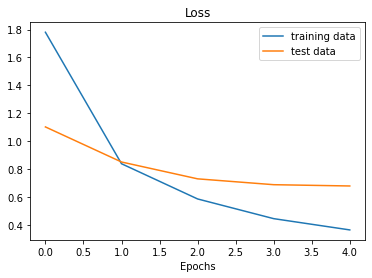

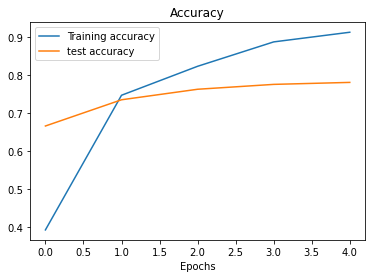

In [19]:
plot_losses_curve(resnet_history)

In [20]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [21]:
efficientnet_model = create_model(efficientnet_url, num_classes=train_data.num_classes)

In [22]:
efficientnet_model.compile(loss=CategoricalCrossentropy(), metrics='accuracy', optimizer='adam')

In [26]:
efficientnet_model_history = efficientnet_model.fit(train_data, validation_data=test_data, steps_per_epoch=len(train_data),
                                                   epochs=5, validation_steps=len(test_data),
                                                   callbacks=[create_tb_callback(dir_name="tensorflow_hub",
                                                                                          exp_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20230107-221831
Epoch 1/5
24/24 [==============================] - 105s 4s/step - loss: 1.5504 - accuracy: 0.5880 - val_loss: 1.1015 - val_accuracy: 0.7932
Epoch 2/5
24/24 [==============================] - 117s 5s/step - loss: 0.9351 - accuracy: 0.8013 - val_loss: 0.7837 - val_accuracy: 0.8264
Epoch 3/5
24/24 [==============================] - 108s 5s/step - loss: 0.6976 - accuracy: 0.8413 - val_loss: 0.6479 - val_accuracy: 0.8492
Epoch 4/5
24/24 [==============================] - 112s 5s/step - loss: 0.5766 - accuracy: 0.8613 - val_loss: 0.5790 - val_accuracy: 0.8584
Epoch 5/5
24/24 [==============================] - 117s 5s/step - loss: 0.4906 - accuracy: 0.8893 - val_loss: 0.5334 - val_accuracy: 0.8628


In [27]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


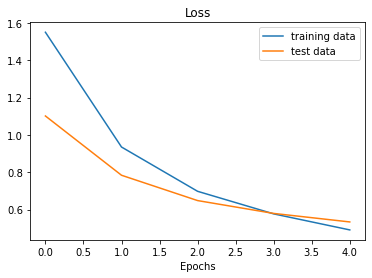

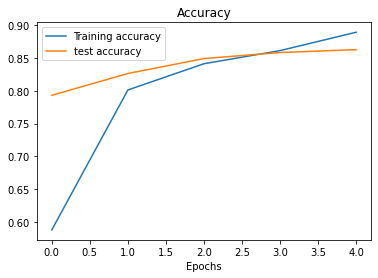

In [28]:
plot_losses_curve(efficientnet_model_history)

In [29]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [30]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________
